# Light curve minima fitter and O-C calculator

This module is for calculating the O-C (Observed – Calculated) diagram of variable stars (see e.g. [Sterken, 2005, ASPC, 335, 3](https://ui.adsabs.harvard.edu/abs/2005ASPC..335....3S/abstract)). The Observed values are calculated by fitting each minimum of a light curve with a pre-defined function. The Calculated values are given by:

$$ C = T_0 + E P ,$$

where $T_0$ is the zero epoch, $E$ is the cycle number and $P$ is the period.

## Choosing the function:

Three kind of functions are available:

- `polynomial`: this is an _n_th order polynomial. The order _n_ is fixed and set by the user. In this case all minima are fitted individually.

- `nonparametric`: this is a nonparametric kernel regression, which is able to fit a minimum with any shape. The smoothnes of the curve is set by the user, however, the default value is usually adequate. In this case all minima are fitted individually.
__Note:__ Very sensitive to outliers!

- `model`: in this case a model is obtained from fitting the median of the phase-folded and vertically shifted light curve. The shifting is done cycle by cycle. The model is developed by nonparametric kernel regression, then shifted and fitted to each minimum while keeping its shape. The smoothness of the model is set by the user, however, the default value is usually adequate:
 - Use ~1 to follow small scale (noise-like) variations
 - Use >1 (e.g. 1.5) to fit a really smooth function

## Estimating errors:

The errors of the minimum times are estimated with brute force, i.e. resampling the light curves _n_ times using known observational errors.

## Important notes:

- If the shape of the minimum of a variable stars varies a lot by time, then it is suggested to fit each minimum individually. Choose a `polynomial` or `nonparametric` model.

- If the shape of the minimum is quasi-constant, then it is suggested to use the default `model` method.

- As only the minima can be fitted, use a magnitude-like (i.e. reversed) scale __to fit the observed maxima__, use a flux-like scale __to fit the observed minima__.

- Always check the fit at first run by setting `showfirst` to `True`. Set the `order` of polynomial or the `smoothness` of the nonparametric model carefully.
  
- The `phase_interval` is the phase interval, which is selected around an expected minimum to fit the selected function. If the sampling is sparse, set a large value (e.g. 0.2-0.4) to contain sufficient number of points around each minima to perform a robust fit.

- The minimum times are calculated (C) using the given period and `epoch`. If `epoch` is not given, then the time stamp of the first minimum is used.

## __How to use__

In [1]:
from seismolab.OC import OCFitter

import numpy as np
import matplotlib.pyplot as plt

We load as an example the light curve of T Men from TESS Sector 1. We assume that the pulsation period is known beforehand. If not, it can calculated with the `seismolab.fourier` module.

In [2]:
lc = np.loadtxt("https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HLSP/qlp/s0001/0000/0000/4041/2372/hlsp_qlp_tess_ffi_s0001-0000000040412372_tess_v01_llc.txt", delimiter=',').T

# Store results in separate arrays for clarity
time       = lc[0]
brightness = lc[1]
brightness_error = np.ones_like(time)*0.01

period = 0.409837

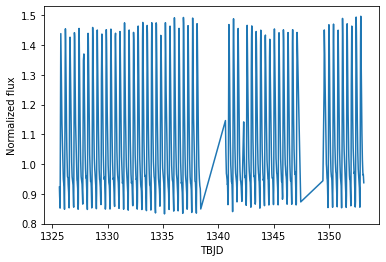

In [3]:
plt.plot(time, brightness)
plt.xlabel("TBJD")
plt.ylabel("Normalized flux")
plt.show()

We assume that we want to fit each maxima, thus we have to revert the flux values as `OCFitter` only fits the minimum times.

In [4]:
brightness = -brightness + 2*np.mean(brightness)

### Performing minima fitting

We initialize the `OCFitter` by passing the light curve and the period. Passing the measurement errors is mandatory!

In [5]:
fitter = OCFitter(time, brightness, brightness_error, period)

Minima fitting is done by calling `fit_minima`.

Calculating minima times...


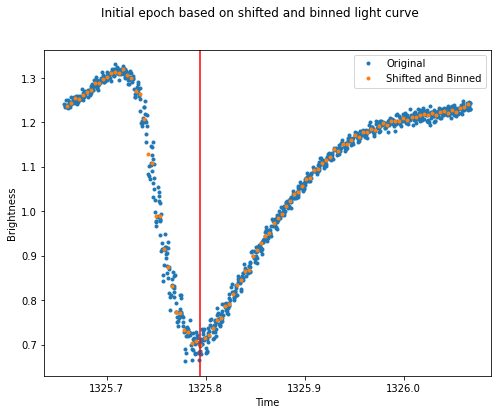

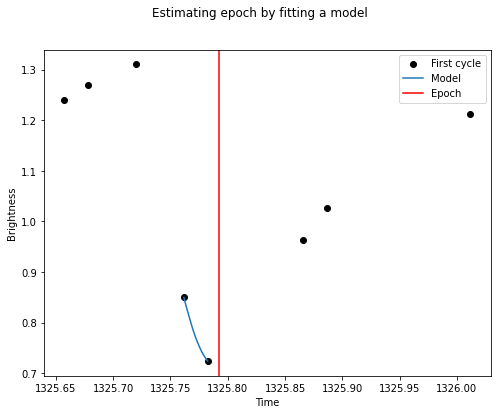

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

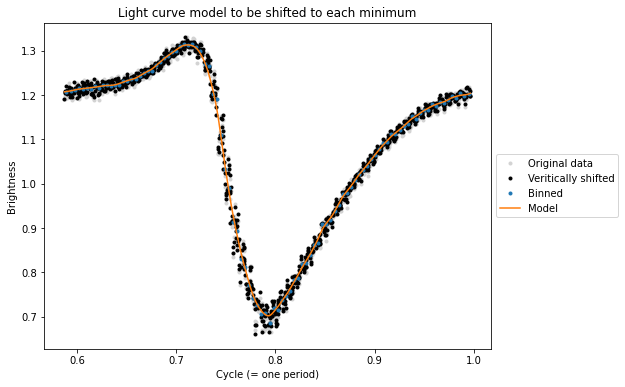

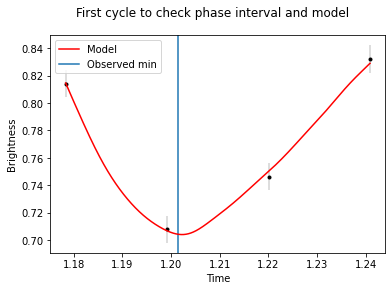

Fitting cycles:  65%|████████████████████           | 37/57 [00:56<00:30,  1.52s/it]

Done!


In [6]:
mintimes,mintimes_err = fitter.fit_minima(showfirst=True)

The results and its errors are stored in two arrays; `mintimes` and `mintimes_err`.

The `showfirst` option generated us someuseful plots that show:

- the phase folded light curve (blue), where each cycle has been vertically shifted to match each other and binned to roughly estimate the epoch, i.e. the minimum time of the first cycle (red vertical line).
- the first cycle (black dots), which is fitted by a smooth model (blue) to estimate the epoch more precisely.
- the phase folded, vertically shifted and binned light curve (same as the first plot), which is fitted by a smooth curve. By default, the `fittype` is `'model'`, for which the model is this fitted smooth curve (now: model). The curve is shifted to and fitted to each minimum to determine the minimum times.
- a part of the first cycle (black dots) with the model curve (red) that has been shifted and fitted to this cycle. This plot can be used to check if
 - the choosen `fittype` fits the minimum well. If not, then change the model type or its parameters.
 - the `phase_interval`, which is 0.1 by default, is large enough to have sufficient number of points to perform the fit and small enough to fit only near the minimum. This plot only shows the set `phase_interval`.

### Calculating the O-C diagram

The O-C diagram is calculated by passing the minimum times, and the period. Optionally, the error of the minimum times can also be passed.

Calculating O-C...


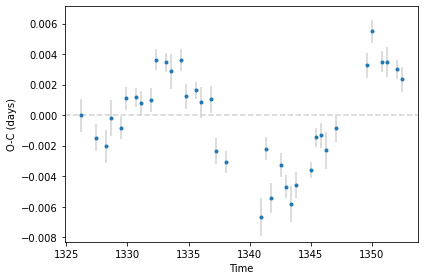

In [7]:
midtimes, OC, OC_err = fitter.calculate_OC(showplot=True)

The results and its errors are stored in three arrays:

- `midtimes` is the passed minimum times,
- `OC` and `OC_err` are the calculated O-C values and the uncertainties.

All available options of `fit_minima` are described below:

In [8]:
mintimes,mintimes_err = fitter.fit_minima(
    fittype='model',    # The type of the fitted function: `poly`, `nonparametric` of `model`.
    
    phase_interval=0.1, # The phase interval around an expected minimum,
                        # which is used to fit the selected function.
    order=3,            # Order of the polynomial to be fitted to each minimum.
                        # Applies only if `fittype` is `poly`.
    smoothness=1,       # The smoothness of fitted nonparametric function.
                        # Use ~1, to follow small scale (noise-like) variations.
                        # Use >1 to fit a really smooth function.
                        # Applies only if `fittype` is `nonparametric` or `model`.
    
    epoch='auto',       # The time stamp of the first minimium.
    
    npools=-1,          # Number of cores during error estimation.
    samplings=100,      # Number of resamplings for error estimation.
    
    showplot=False,     # Show each fitted minima and other useful plots.
    saveplot=False,     # Save all plots.
    showfirst=False,    # Show plots used to check parameters of the fitted function.
    filename=''         # Filename without extension to save plots.
)

Calculating minima times...


Fitting cycles:  65%|████████████████████           | 37/57 [00:53<00:28,  1.44s/it]

Done!


All available options of `calculate_OC` are described below:

In [9]:
midtimes, OC, OC_err = fitter.calculate_OC(
    min_times=None,     # Observed (O) times of minima; otherwise use from the `fitter`
    period=None,        # Period to be used to construct calculated (C) values; otherwise use from the `fitter`
    epoch=None,         # Epoch to be used to construct calculated (C) values; otherwise use from the `fitter`
    min_times_err=None, # Error of observed (O) times of minima; otherwise use from the `fitter`
    
    showplot=False,     # Show results
    saveplot=False,     # Save results
    saveOC=True,        # Save constructed OC as txt file
    filename=''         # Filename without extension
)

Calculating O-C...


### Choosing the model to be fitted

The `poly` model requires to fine tune the polynomial order and the phase interval to be fitted around each expected minimum. As this light curve is sparsly sampled, we can increase the phase interval to e.g. 0.3. To do not overfit the minima, we keep the order as low as 3.

Calculating minima times...


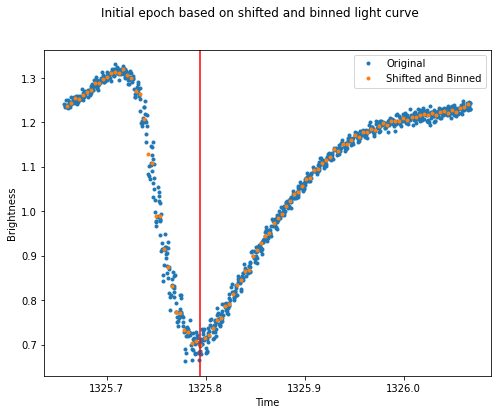

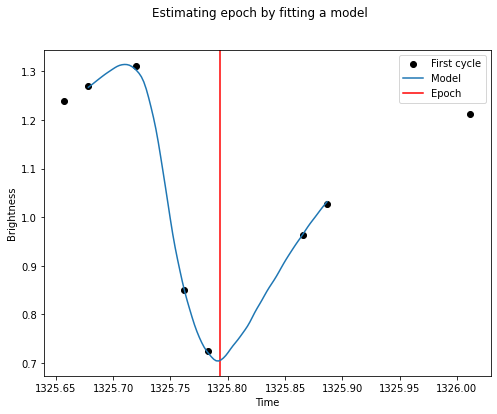

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

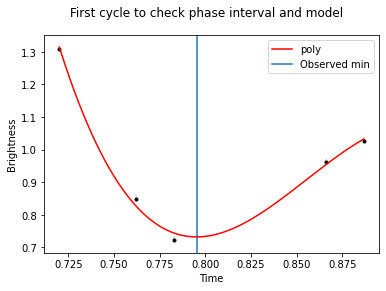

Fitting cycles:  95%|█████████████████████████████▎ | 54/57 [00:05<00:00, 10.10it/s]

Done!


In [10]:
mintimes,mintimes_err = fitter.fit_minima(fittype='poly',
                                          phase_interval=0.3,
                                          order=3,

                                          showfirst=True)

Calculating O-C...


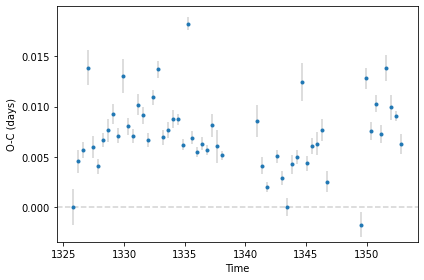

In [11]:
midtimes, OC, OC_err = fitter.calculate_OC(showplot=True)

The `nonparametric` model requires to fine tune the smoothness and the phase interval to be fitted around each expected minimum. As this light curve is sparsly sampled, we can increse the phase interval to e.g. 0.3. To do not overfit the minima, we keep the smoothness at its default value of 1.

Calculating minima times...


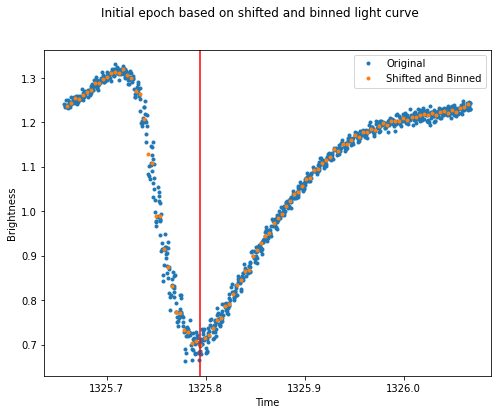

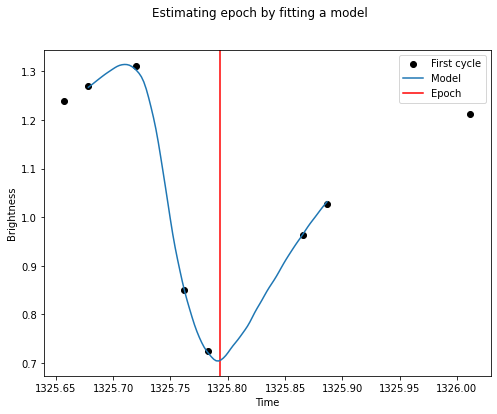

Fitting cycles:   0%|                                        | 0/57 [00:00<?, ?it/s]

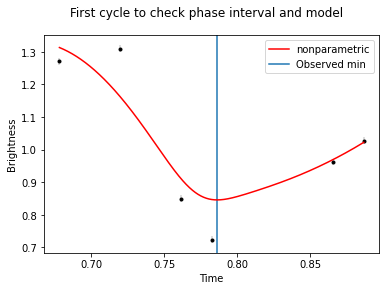

Fitting cycles:  95%|█████████████████████████████▎ | 54/57 [00:13<00:00,  4.11it/s]

Done!


In [12]:
mintimes,mintimes_err = fitter.fit_minima(fittype='nonparametric',
                                          phase_interval=0.3,
                                          smoothness=1,

                                          showfirst=True)

Calculating O-C...


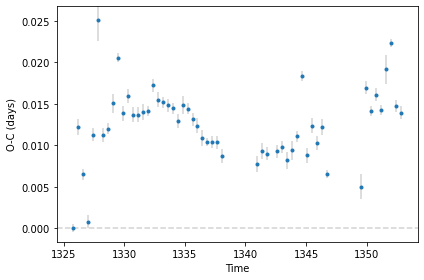

In [13]:
midtimes, OC, OC_err = fitter.calculate_OC(showplot=True)